Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

CUDA setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1. Preparar os Dados

In [3]:
PATH = 'data/Session_1_ground'
PATH_TRAIN = os.path.join(PATH, 'train')
PATH_TEST = os.path.join(PATH, 'test')
BATCH_SIZE = 16
dic_classes = {'not_jumping': 0, 'jumping': 1}

IMG_WIDTH = 320
IMG_HEIGHT = 240

In [4]:
def preprocessar(imagem):
    imagem = np.array(imagem)
    data_mean = np.mean(imagem)
    data_std = np.std(imagem)
    imagem = (imagem - data_mean) / data_std
    xmax, xmin = imagem.max(), imagem.min()
    imagem = (imagem - xmin)/(xmax - xmin)
    imagem = imagem.transpose(2,1,0)
    return imagem

class JumpingDataset(Dataset):

    def __init__(self, path, mun_imagens = 0, transforms=None):
        files = os.listdir(path)
        files = [os.path.join(path,f) for f in files]
        if mun_imagens == 0:
            mun_imagens = len(files)
        self.mun_imagens = mun_imagens
        self.files = random.sample(files, self.mun_imagens)
        self.transforms = transforms
        
    def __len__(self):
        return self.mun_imagens

    def __getitem__(self, idx):
        fich_imagem = self.files[idx]
        imagem = Image.open(fich_imagem)
        imagem = preprocessar(imagem)
        
        # fich_imagem: data/Session_1_ground/train/501_not_jumping.jpg
        image_name = fich_imagem.split('/')[-1]

        # Image name: 501_not_jumping.jpg or 501_jumping.jpg
        label_classe = image_name.split("_", 1)[-1].split(".")[0]

        label = dic_classes[label_classe]
        imagem = imagem.astype(np.float32)
        if self.transforms:
            imagem = self.transforms(imagem)
        return imagem, label

def prepare_data_loaders(path_train, path_test):
    dataset_train = JumpingDataset(path_train,transforms=None)
    dataset_test = JumpingDataset(path_test,transforms=None)
    
    val_size = 96 # TODO: HARDCODED
    train_size = len(dataset_train) - val_size
    train, validation = random_split(dataset_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=True)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=True)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [5]:
from IPython.display import display

def visualize_data(path):
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train_dl, test_dl, dataset_train, dataset_test):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Validação:{len(val_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    
    print(f'Valor maximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')
    x=x.detach().numpy()
    print(f'Valor maximo:{np.max(x)} Valor mínimo:{np.min(x)}')
    print(y)
    
visualize_dataset(train_dl, test_dl, train_dl_all, test_dl_all)

Quantidade de casos de Treino:431
Quantidade de casos de Validação:96
Quantidade de casos de Teste:96
Shape tensor batch casos treino, input: torch.Size([16, 3, 320, 240]), output: torch.Size([16])
Shape tensor batch casos validação, input: torch.Size([16, 3, 320, 240]), output: torch.Size([16])
Shape tensor batch casos test, input: torch.Size([16, 3, 320, 240]), output: torch.Size([16])
Valor maximo:1.0 Valor mínimo:0.0
Valor maximo:1.0 Valor mínimo:0.0
tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0])


Shape tensor batch, input: torch.Size([16, 3, 320, 240]), output: torch.Size([16])
Valor maximo:1.0 Valor mínimo:0.0
tensor([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1])


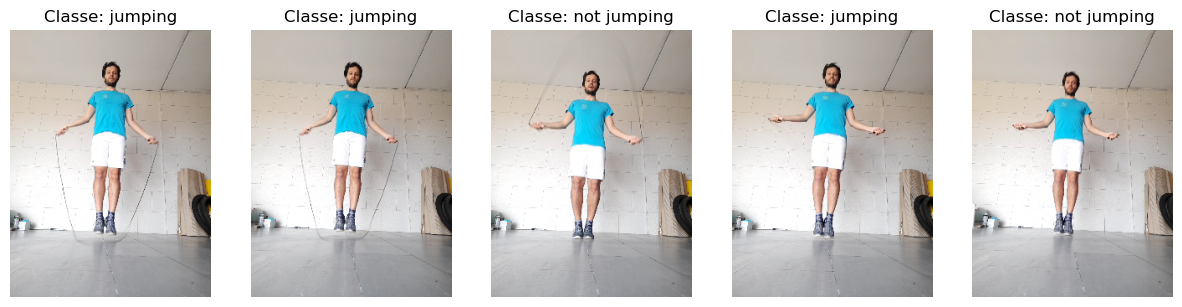

In [6]:
def visualize_images(dl, num_images=5):
    x, y = next(iter(dl))
    print(f"Shape tensor batch, input: {x.shape}, output: {y.shape}")
    x=x.detach().numpy()
    print(f'Valor maximo:{np.max(x)} Valor mínimo:{np.min(x)}')
    print(y)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Rotate the image on y axis and transpose
        axs[i].imshow(x[i].transpose(1,2,0))
        
        class_name = 'jumping' if y[i] == 1 else 'not jumping'
        axs[i].set_title(f'Classe: {class_name}')
        axs[i].axis('off')
    plt.show()

visualize_images(train_dl, num_images=5)

## 1.2 Verificar balanceamento do dataset

-----------------------------------casos_treino-----------------------------------
casos: 431
['0', '1']
[264 167]
431


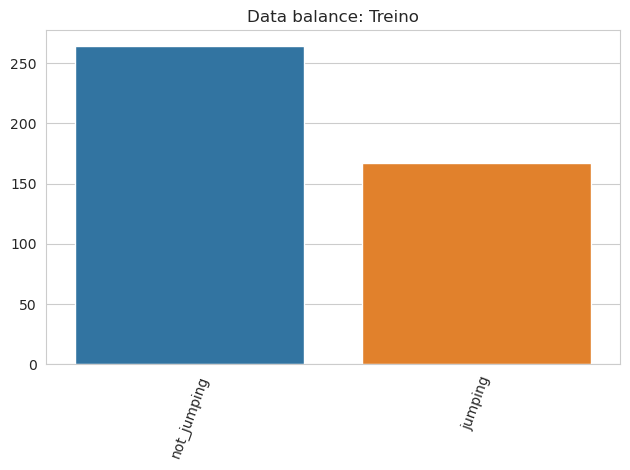

-----------------------------------casos_validação-----------------------------------
casos: 96
['0', '1']
[51 45]
96


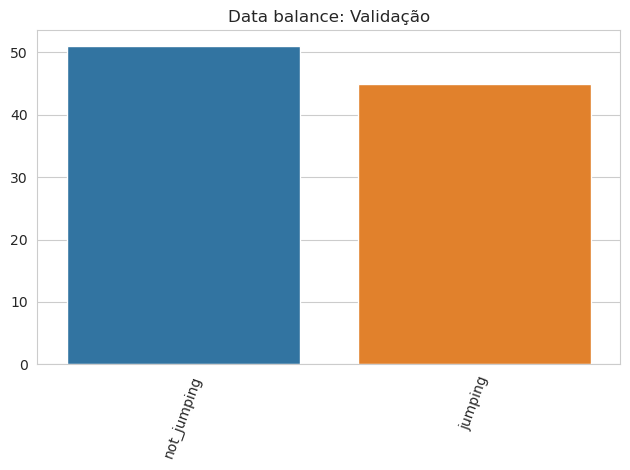

-----------------------------------casos_teste-----------------------------------
casos: 96
['0', '1']
[54 42]
96


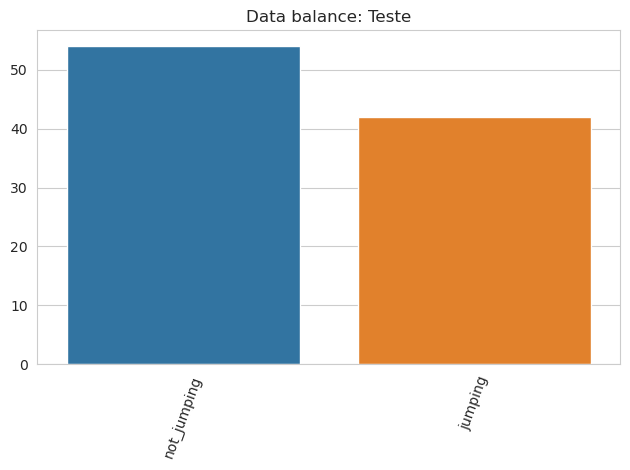

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(dl, titulo):
    _, labels = next(iter(dl))                            
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x_ext=[list(dic_classes.keys())[n] for n in x]
    print([str(n)  for n in x])
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x=x_ext, y=y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 
    
print("-----------------------------------casos_treino-----------------------------------")   
visualize_holdout_balance(train_dl_all, 'Treino')
print("-----------------------------------casos_validação-----------------------------------")   
visualize_holdout_balance(val_dl_all, 'Validação')
print("-----------------------------------casos_teste-----------------------------------") 
visualize_holdout_balance(test_dl_all, 'Teste')

## 2. Definir o Modelo

In [8]:
class BaseModel(Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        #self.conv1 = Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        #self.conv2 = Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        #self.fc1 = Linear(2*IMG_WIDTH*IMG_HEIGHT, 128)
        #self.fc2 = Linear(128, 10)
        #self.maxpool = MaxPool2d(kernel_size=2, stride=2)
        #self.relu = ReLU()
        self.conv1 = Conv2d(3, 16, kernel_size=10, stride=1, padding=2)
        self.conv2 = Conv2d(16, 32, kernel_size=10, stride=1, padding=1)
        self.conv3 = Conv2d(32, 64, kernel_size=7, stride=1, padding=1)
        self.fc1 = Linear(56000, 128)
        self.fc2 = Linear(128, 2)
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)
        self.relu = ReLU()

    def forward(self, x):
        #x = self.conv1(x)
        #x = self.relu(x)
        #x = self.maxpool(x)
        #x = self.conv2(x)
        #x = self.relu(x)
        #x = self.maxpool(x)
        #x = x.view(x.size(0), -1)
        #x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = BaseModel()
# input_size = (BATCH_SIZE, channels, height, width)
print(summary(model, input_size=(BATCH_SIZE, 3, IMG_WIDTH, IMG_HEIGHT), verbose=0))
print(model)


Layer (type:depth-idx)                   Output Shape              Param #
BaseModel                                [16, 2]                   --
├─Conv2d: 1-1                            [16, 16, 315, 235]        4,816
├─ReLU: 1-2                              [16, 16, 315, 235]        --
├─MaxPool2d: 1-3                         [16, 16, 157, 117]        --
├─Conv2d: 1-4                            [16, 32, 150, 110]        51,232
├─ReLU: 1-5                              [16, 32, 150, 110]        --
├─MaxPool2d: 1-6                         [16, 32, 75, 55]          --
├─Conv2d: 1-7                            [16, 64, 71, 51]          100,416
├─ReLU: 1-8                              [16, 64, 71, 51]          --
├─MaxPool2d: 1-9                         [16, 64, 35, 25]          --
├─Linear: 1-10                           [16, 128]                 7,168,128
├─ReLU: 1-11                             [16, 128]                 --
├─Linear: 1-12                           [16, 2]                  

/home/rubensas/anaconda3/envs/MEI_SI_AP/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


## 3. Treinar o Modelo

In [9]:
EPOCHS = 50
LEARNING_RATE = 0.001
MOMENTUM = 0.9

In [10]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    model.to(device)
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()
    
    torch.save(model.state_dict(), h5_file)

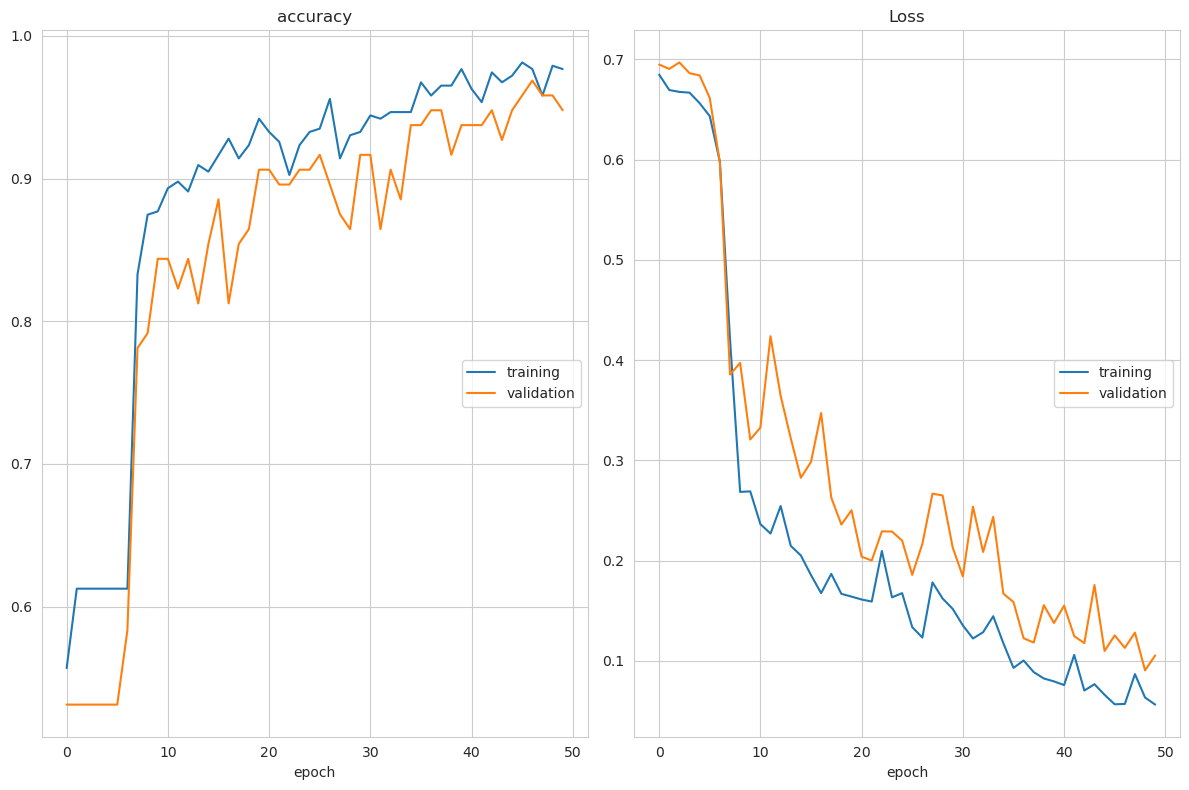

accuracy
	training         	 (min:    0.557, max:    0.981, cur:    0.977)
	validation       	 (min:    0.531, max:    0.969, cur:    0.948)
Loss
	training         	 (min:    0.056, max:    0.685, cur:    0.056)
	validation       	 (min:    0.090, max:    0.697, cur:    0.105)
Training took 403.6017 seconds


In [11]:
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
start_time = time.perf_counter()
train_model('model.h5', train_dl, val_dl, model, criterion, optimizer)
end_time = time.perf_counter()
print(f"Training took {end_time - start_time:0.4f} seconds")

## 4. Avaliar o Modelo

real:jumping previsão:jumping
real:jumping previsão:jumping
real:not_jumping previsão:not_jumping
real:not_jumping previsão:not_jumping
real:jumping previsão:jumping
real:jumping previsão:jumping
real:jumping previsão:jumping
real:not_jumping previsão:not_jumping
real:not_jumping previsão:not_jumping
real:not_jumping previsão:not_jumping
real:jumping previsão:jumping
real:jumping previsão:jumping
real:jumping previsão:jumping
real:not_jumping previsão:not_jumping
real:jumping previsão:jumping
real:jumping previsão:jumping
real:jumping previsão:jumping
real:jumping previsão:jumping
real:jumping previsão:jumping
real:not_jumping previsão:not_jumping
Accuracy: 1.000

acertou:96 falhou:0
Accuracy: 1.000

acertou:96 falhou:0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        42

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        9

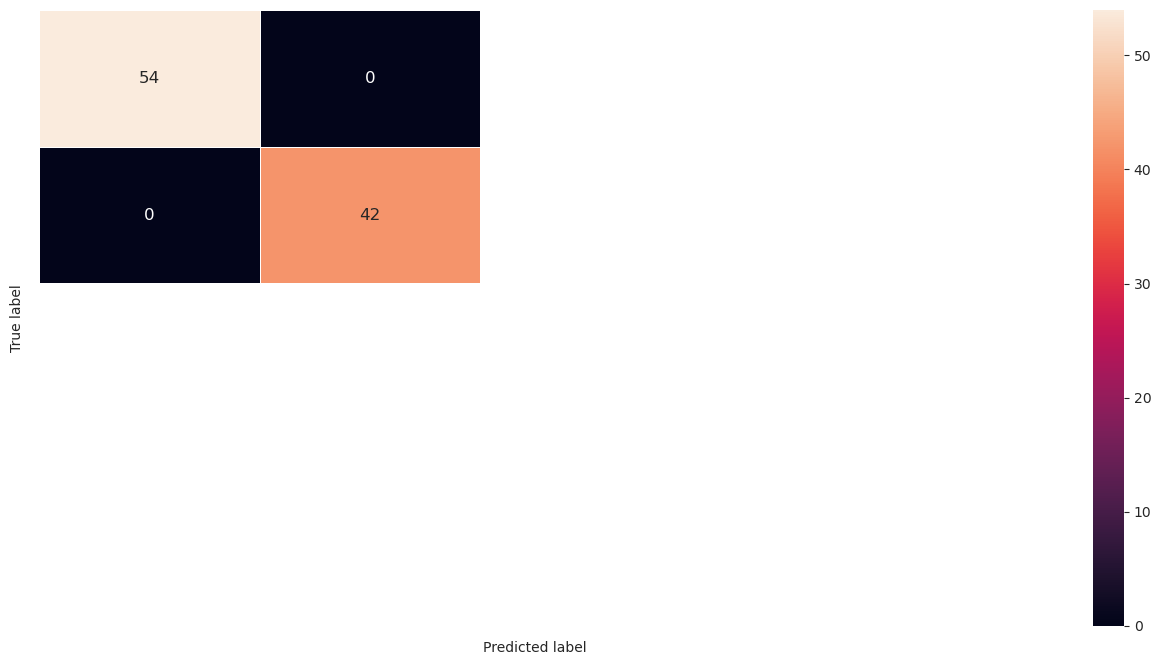

In [12]:
def output_label(label):
    for text_label in dic_classes:
        if label == dic_classes[text_label]:
            return text_label

def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        yprev = model(inputs)
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou=0
    falhou = 0
    primeiros=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            r = output_label(r)
            p = output_label(p)
            print(f'real:{r} previsão:{p}') 
            primeiros +=1
        if r==p: acertou+=1  
        else: falhou+=1
    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    

model = BaseModel()
model.load_state_dict(torch.load('model.h5'))
actual_values, predictions = evaluate_model(test_dl_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n) for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

display_confusion_matrix(cm,list_classes)

## 5. Usar o Modelo

In [13]:
def make_prediction(model, img): 
    img = img.reshape(1,3,IMG_WIDTH,IMG_HEIGHT)
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    return output_label(prediction)

    print(f'Prediction: {output_label(prediction)}')
    img = img.cpu()
    plt.axis('off')
    plt.imshow(img[0,0].transpose(0,1), cmap=plt.get_cmap('gray'))
    plt.show()

model = BaseModel()
model.load_state_dict(torch.load('model.h5'))

# Load all images paths from the 'data/Session_1_ground/all'
all_images = os.listdir('data/Session_1_ground/all')
all_images = [os.path.join('data/Session_1_ground/all', f) for f in all_images]

# Sort the images by the first number in the file name. For example, 501_not_jumping.jpg or 501_jumping.jpg
all_images = sorted(all_images, key=lambda x: int(x.split('/')[-1].split('_')[0]))


last_was_jumping = False
jump_count = 0
for img_path in all_images:
    img = Image.open(img_path)
    img = preprocessar(img)
    img = img.astype(np.float32)
    img = Tensor(img)
    pred = make_prediction(model, img)
    if pred == 'jumping':
        if last_was_jumping == False:
            jump_count += 1
            print(f'Jump #{jump_count}')
            last_was_jumping = True
    else:
        last_was_jumping = False


Jump #1
Jump #2
Jump #3
Jump #4
Jump #5
Jump #6
Jump #7
Jump #8
Jump #9
Jump #10
Jump #11
Jump #12
Jump #13
Jump #14
Jump #15
Jump #16
Jump #17
Jump #18
Jump #19
Jump #20
Jump #21
Jump #22
Jump #23
Jump #24
Jump #25
Jump #26
Jump #27
Jump #28
Jump #29
Jump #30
Jump #31
Jump #32
Jump #33
Jump #34
Jump #35
Jump #36
Jump #37
Jump #38
Jump #39
Jump #40
Jump #41
Jump #42
Jump #43
Jump #44
Jump #45
Jump #46
Jump #47
Jump #48
Jump #49


## 6. Exportar o Modelo para Android

In [14]:
from torch.utils.mobile_optimizer import optimize_for_mobile

def export_to_ptlite(model_file, model_ptl):
    model = BaseModel()
    model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu'))) # On CPU (for mobile)
    model.eval()

    scripted_model = torch.jit.script(model)
    optimized_model = optimize_for_mobile(scripted_model)
    optimized_model._save_for_lite_interpreter(model_ptl)

export_to_ptlite('model.h5', 'model.ptl')